Fraud detection problems is one of the top priorities for banks and financial institutions.

Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc,classification_report
import lightgbm as lgb
from scipy.stats import randint as sp_randint

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')


['creditcard.csv']


Import the dataset

Where variables from V1-V28 is generated by PCA reduction technique.

In [2]:
ccfd_df=pd.read_csv('../input/creditcard.csv')
print(ccfd_df.shape)
ccfd_df.head(10)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Dataset is highly unbalanced and it can be controlled by 'is_unbalance' function in Lightgbm library.


In [3]:
ccfd_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Normalize the class labels

In [4]:
ccfd_df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

Split the dataset by train_test_split function.

In [5]:
X_train,X_test,y_train,y_test=train_test_split(ccfd_df.drop('Class',axis=1),ccfd_df['Class'],test_size=0.2)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(227845, 30) (56962, 30)
(227845,) (56962,)


Normalize the y labels

In [6]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

0    227435
1       410
Name: Class, dtype: int64
0    0.998201
1    0.001799
Name: Class, dtype: float64
0    56880
1       82
Name: Class, dtype: int64
0    0.99856
1    0.00144
Name: Class, dtype: float64


Training the lgbm model

In [7]:
lgb_train=lgb.Dataset(X_train,y_train)
lgb_train

Select the hyperparameters

In [8]:
parameters={'boosting_type': 'gbdt', 
          'max_depth' : -1, #no limit for max_depth if <0
          'objective': 'binary',
          'boost_from_average':True, 
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,      #default 255
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2, #L1 regularization(>0)
          'reg_lambda': 1.2,#L2 regularization(>0)
          'min_split_gain': 0.5, #>0
          'min_child_weight': 1,
          'min_child_samples': 5,
          'is_unbalance':True,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error',
            'task':'train'
          }


Create the LGBMClassifier

In [9]:
clf=lgb.LGBMClassifier(parameters,lgb_train,num_iterations=300,silent=True,random_state=32)
print(clf)

LGBMClassifier(boosting_type={'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'boost_from_average': True, 'nthread': 5, 'num_leaves': 64, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'is_unbalance': True, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error', 'task': 'train'},
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_iterations=300,
        num_leaves=<lightgbm.basic.Dataset object at 0x7f3276ccb4e0>,
        objective=None, random_state=32, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)


RandomizedCV algorithm for hyperparameter tuning

Randomized parameters

In [10]:
randomparams={'learning_rate': [0.02,0.04],
    'n_estimators':[8,16],
    'num_leaves': [160, 800, 2000],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [32], 
    'colsample_bytree' :[0.64, 0.65],
    'subsample' : [0.7,0.75],
    'max_depth':[8,10,15],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

Randomized SearchCV algorithm

In [11]:
rscv=RandomizedSearchCV(clf,randomparams,n_jobs=-1,cv=5,random_state=32)
rscv

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type={'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'boost_from_average': True, 'nthread': 5, 'num_leaves': 64, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 'reg_alp..._lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.02, 0.04], 'n_estimators': [8, 16], 'num_leaves': [160, 800, 2000], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'random_state': [32], 'colsample_bytree': [0.64, 0.65], 'subsample': [0.7, 0.75], 'max_depth': [8, 10, 15]},
          pre_dispatch='2*n_jobs', random_state=32, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Fit the model

In [12]:
rscv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type={'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'boost_from_average': True, 'nthread': 5, 'num_leaves': 64, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.8, 'reg_alp..._lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.02, 0.04], 'n_estimators': [8, 16], 'num_leaves': [160, 800, 2000], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'random_state': [32], 'colsample_bytree': [0.64, 0.65], 'subsample': [0.7, 0.75], 'max_depth': [8, 10, 15]},
          pre_dispatch='2*n_jobs', random_state=32, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Print the best_score and best_params

In [13]:
print(rscv.best_score_)
print(rscv.best_params_)

0.9995611051372644
{'subsample': 0.75, 'random_state': 32, 'objective': 'binary', 'num_leaves': 800, 'n_estimators': 8, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.64, 'boosting_type': 'gbdt'}


Replace params with best_params

In [14]:
parameters['num_leaves']=rscv.best_params_['num_leaves']
parameters['colsample_bytree']=rscv.best_params_['colsample_bytree']
parameters['subsample']=rscv.best_params_['subsample']
parameters['learning_rate']=rscv.best_params_['learning_rate']
print(parameters)

{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'boost_from_average': True, 'nthread': 5, 'num_leaves': 800, 'learning_rate': 0.02, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'is_unbalance': True, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error', 'task': 'train'}


Training the model with optimized params

In [15]:
lgbm=lgb.train(parameters,lgb_train,200,verbose_eval=4)
lgbm

Test the trained model

In [16]:
lgb_predict_prob=lgbm.predict(X_test,random_state=32)
lgb_predict=np.where(lgb_predict_prob>0.5,1,0)#Turn the probability to 0-1 binary output
lgb_predict

array([0, 0, 0, ..., 0, 0, 0])

plot variable importance

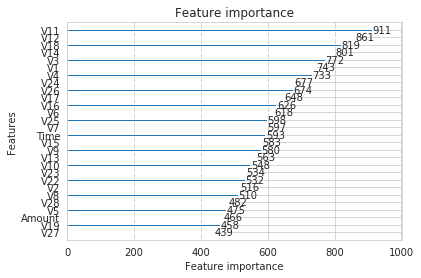

In [17]:
lgb.plot_importance(lgbm,max_num_features=28,importance_type="split")

Overall accuracy of Lightgbm

In [18]:
acc_lgb=accuracy_score(y_test,lgb_predict)
acc_lgb

0.9993153330290369

Plot the ROC curve and print the area under the curve

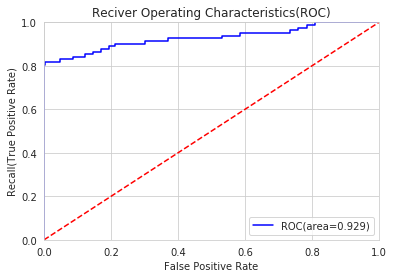

AUC: 0.9285451185208053


In [19]:
plt.figure()
false_positive_rate,recall,thresholds=roc_curve(y_test,lgb_predict_prob)
roc_auc=auc(false_positive_rate,recall)
plt.title('Reciver Operating Characteristics(ROC)')
plt.plot(false_positive_rate,recall,'b',label='ROC(area=%0.3f)' %roc_auc)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall(True Positive Rate)')
plt.xlabel('False Positive Rate')
plt.show()
print('AUC:',roc_auc)

Plot the confusion matrix

[[56857    23]
 [   16    66]]


<Figure size 432x288 with 0 Axes>

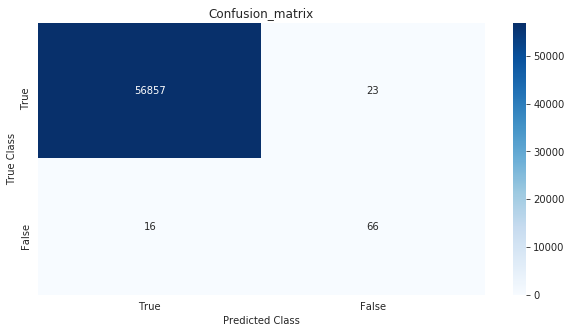

In [20]:
plt.figure()
cm=confusion_matrix(y_test,lgb_predict)
print(cm)
labels=['True','False']
plt.figure(figsize=(10,5))
sns.heatmap(cm,xticklabels=labels,yticklabels=labels,cmap='Blues',vmin=0.2,annot=True,fmt='d')
plt.title('Confusion_matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


print the classification report

In [21]:
print(classification_report(y_test,lgb_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56880
           1       0.74      0.80      0.77        82

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.87      0.90      0.89     56962
weighted avg       1.00      1.00      1.00     56962

